# Practical session n°5

Notions:
- Semantic segmentation
- Intersection over Union
- Image Denoising
- Fully convolutional networks, U-Net
- Weak supervision (in part II): The noise-to-noise and the Neural Eggs Separation scenarios.

Duration: 1 h 30 + 2 h

In P3, we illustrated how Convolutional Neural Networks (CNNs) are trained for image classification tasks. In this practical session, we demonstrate how to achieve pixel-level predictions for tasks like semantic segmentation and image denoising.

To start, we’ll simply apply an off-the-shelf model. Then, we’ll focus on training a model from scratch (part I, exercise 2 and part II).

In P3, we also introduced a crucial set of methods known as "transfer learning," which is particularly effective when there’s limited training data. In this session, we’ll explore another equally important set of methods called "weak supervision," which is well-suited for cases where ground truth is imperfectly known (Part II).

## Part II: denoising with FCN - weakly-supervised approaches




In [22]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [23]:
! git clone https://github.com/nanopiero/ML_S5_etudiants
! cp ML_S5_etudiants/practicals/P5/utile.py .
from utile import gen_noise2noise, voir_batch2D,UNet

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


###**Exercise 1: The "noise to noise" scenario**

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The *gen_noise2noise* function allows us to sample from both datasets:

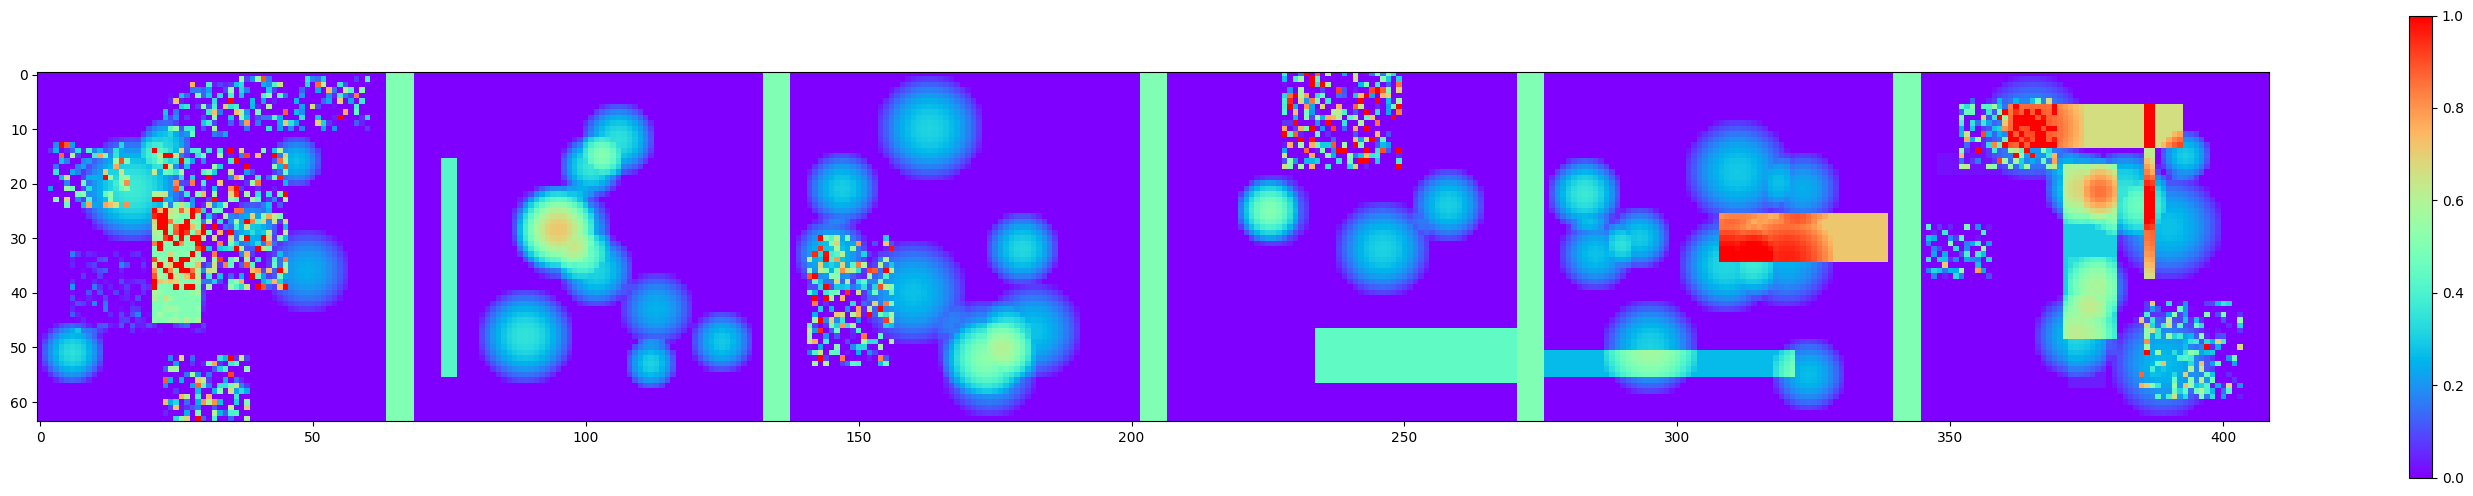

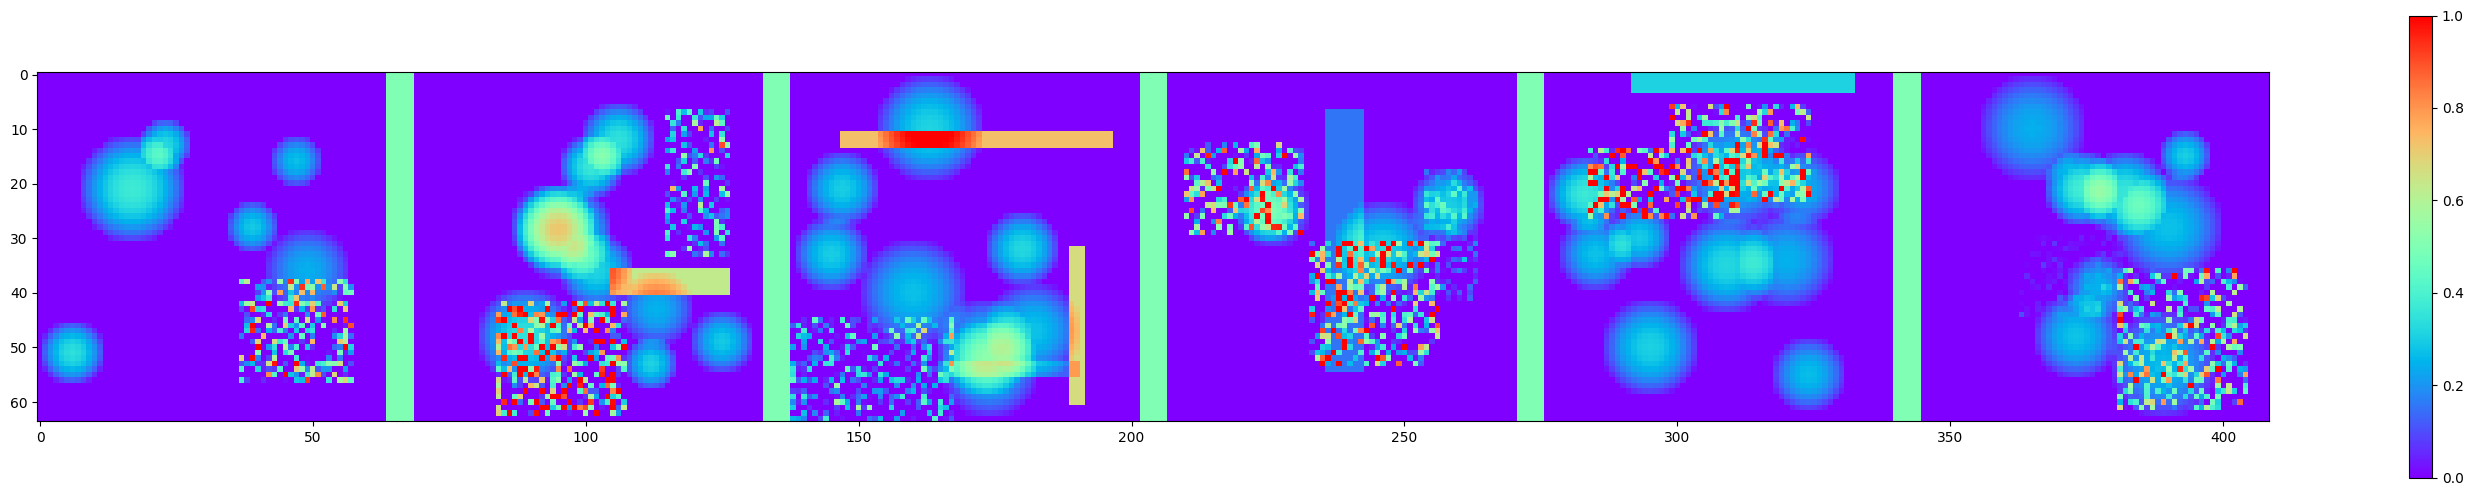

In [9]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1:** Define a learning procedure that effectively denoises the image.

In [12]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [19]:
nepochs = 40
nbatches = 100
batchsize = 64

#criterion = nn.MSELoss()
criterion = nn.L1Loss()

for epoch in range(nepochs):
    running_loss = 0.0

    for i in range(nbatches):
        input, target = gen_noise2noise(batchsize)

        #Envoi des données sur le GPU
        input = input.cuda()
        target = target.cuda()

        optimizer.zero_grad()

        output = fcn(input)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{nepochs} - Loss: {running_loss/nbatches:.5f}")

Epoch 1/40 - Loss: 0.08522
Epoch 2/40 - Loss: 0.07688
Epoch 3/40 - Loss: 0.07758
Epoch 4/40 - Loss: 0.07745
Epoch 5/40 - Loss: 0.07612
Epoch 6/40 - Loss: 0.07598
Epoch 7/40 - Loss: 0.07583
Epoch 8/40 - Loss: 0.07634
Epoch 9/40 - Loss: 0.07636
Epoch 10/40 - Loss: 0.07501
Epoch 11/40 - Loss: 0.07642
Epoch 12/40 - Loss: 0.07518
Epoch 13/40 - Loss: 0.07624
Epoch 14/40 - Loss: 0.07715
Epoch 15/40 - Loss: 0.07570
Epoch 16/40 - Loss: 0.07587
Epoch 17/40 - Loss: 0.07533
Epoch 18/40 - Loss: 0.07483
Epoch 19/40 - Loss: 0.07637
Epoch 20/40 - Loss: 0.07472
Epoch 21/40 - Loss: 0.07672
Epoch 22/40 - Loss: 0.07533
Epoch 23/40 - Loss: 0.07518
Epoch 24/40 - Loss: 0.07567
Epoch 25/40 - Loss: 0.07557
Epoch 26/40 - Loss: 0.07566


KeyboardInterrupt: 

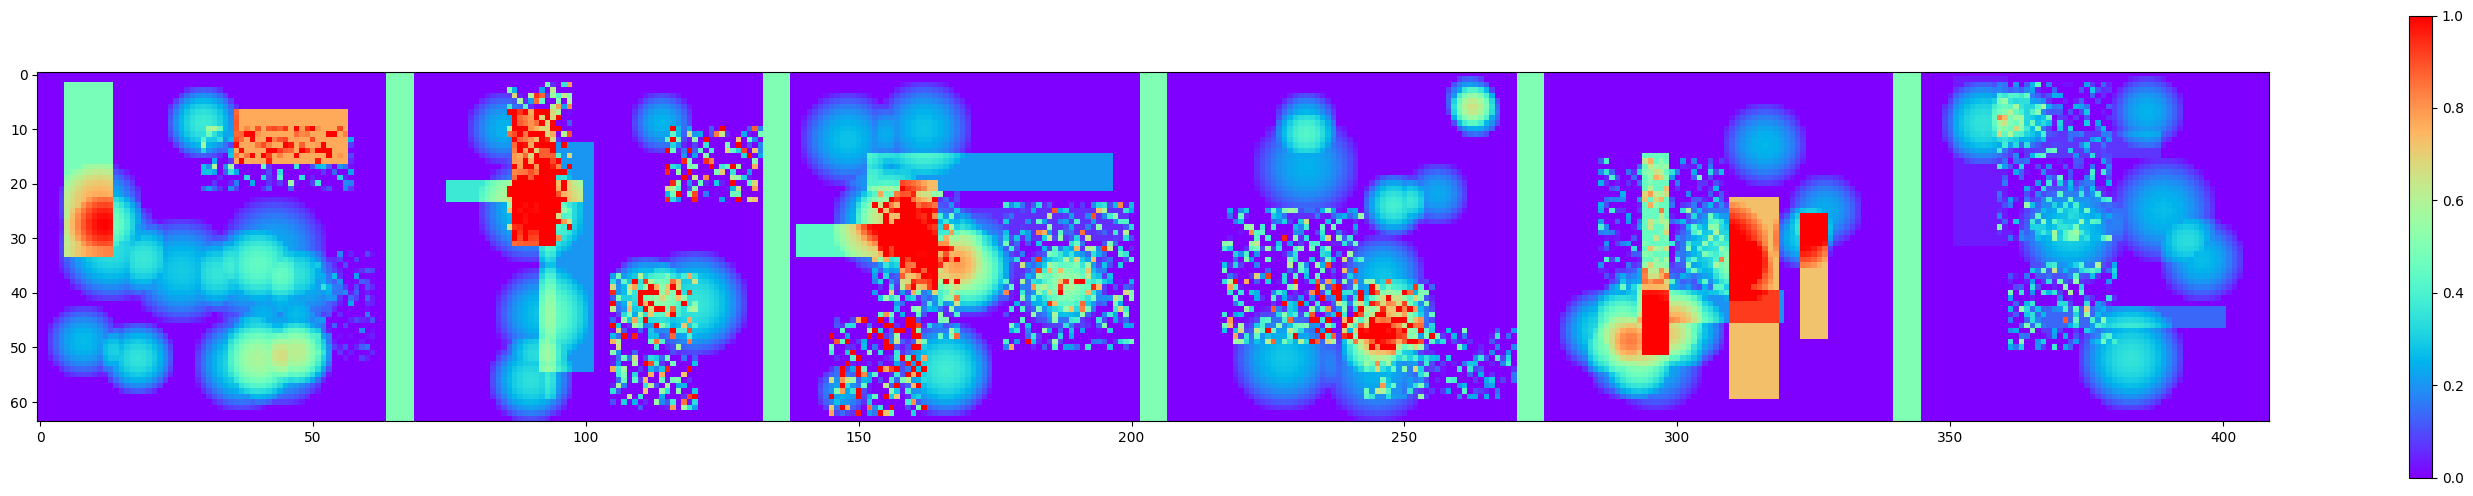

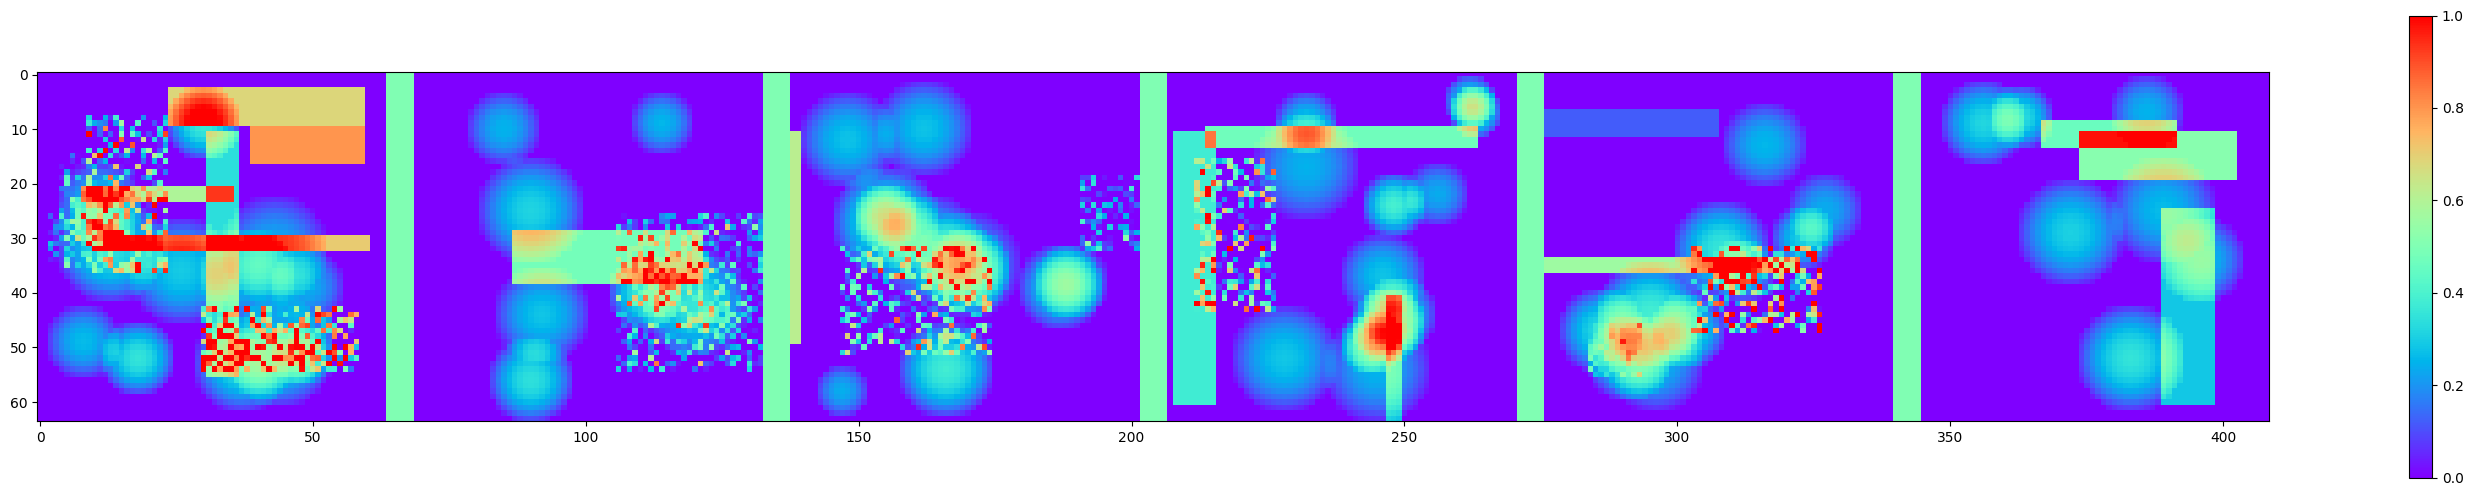

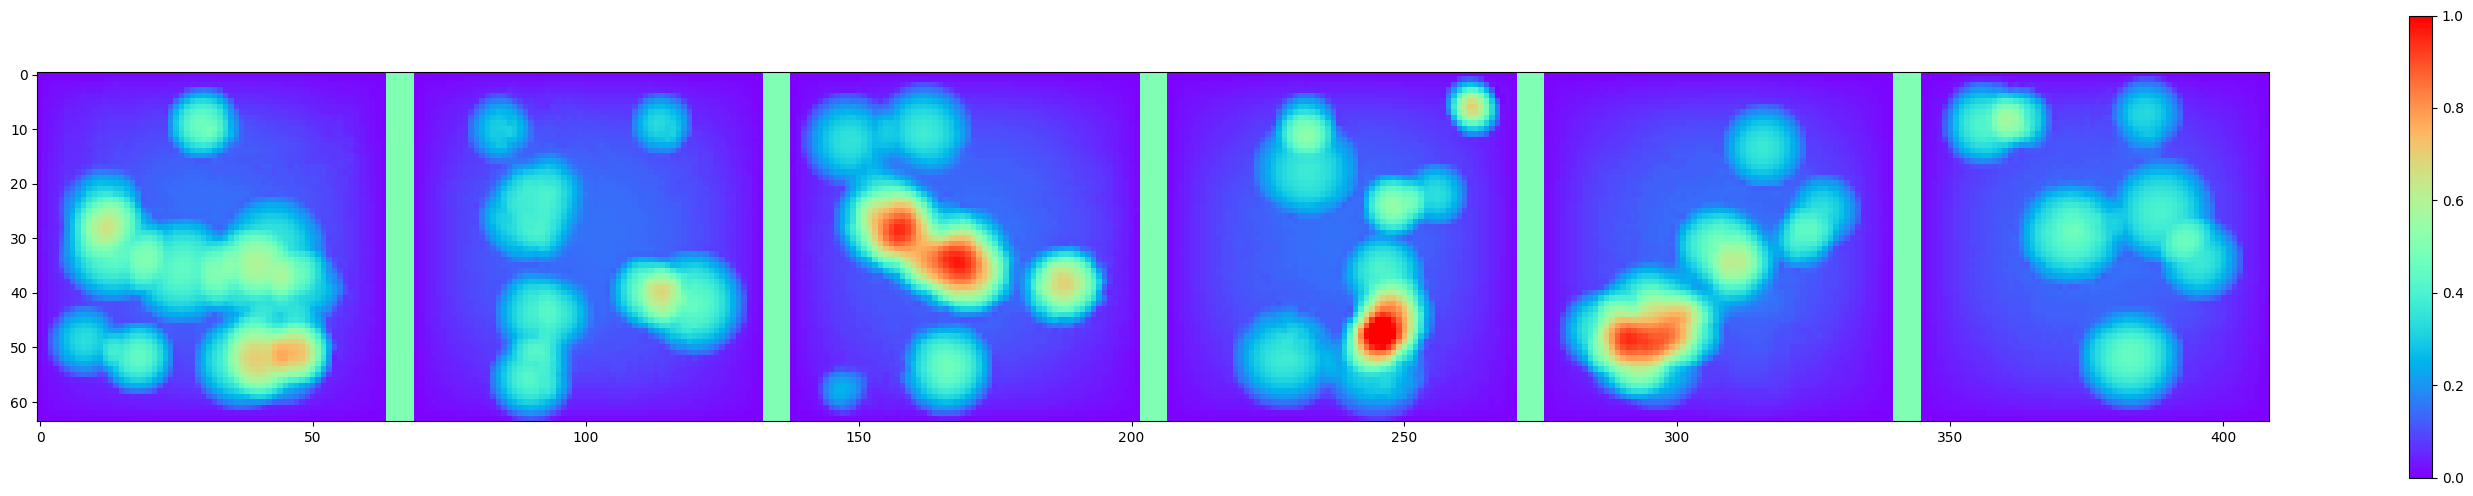

In [18]:
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs


**Q2:** Theoretical analysis:

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite $\mathbb{E}_{(X,Y)}[ \mathcal{L} (f_\theta(X), Y) ]$ to justify the approach taken for **Q1**.



...


###**Exercise 2: The "NES" scenario (Neural Egg Separation)**

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).   



In [21]:
from utilie import gen1_NES, gen2_NES
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

ModuleNotFoundError: No module named 'utilie'

**Q1:** Propose a learning strategy that leads to effective denoising.

**Q2:** Discuss the limitations of the method and mention some avenues for improvement.

# Task
Implement the training loop for the denoising task using the 'noise to noise' scenario, including data generation, forward pass, loss calculation, backpropagation, and optimizer step, then execute the implemented training loop to train the UNet model, and finally analyze the training process by checking the output after training, observing the denoised images and comparing them to the input and target images.

## implement_training_loop

### Subtask:
Implement the training loop for the denoising task using the 'noise to noise' scenario, including data generation, forward pass, loss calculation, backpropagation, and optimizer step.


**Reasoning**:
I need to implement the training loop as described in the instructions, which involves iterating through epochs and batches, generating data, performing forward and backward passes, calculating loss, and updating model weights. This code will execute the core training process for the denoising model.



In [15]:
loss_list = []

for epoch in range(nepochs):
    fcn.train()
    running_loss = 0.0
    for i in range(nbatches):
        # Generate a batch of noisy image pairs
        input, target = gen_noise2noise(batchsize)
        input = input.cuda()
        target = target.cuda()

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = fcn(input)

        # Calculate MSE loss
        loss = F.mse_loss(output, target)

        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / nbatches
    loss_list.append(epoch_loss)

    print(f"Epoch {epoch+1}/{nepochs}, Loss: {epoch_loss:.4f}")

Epoch 1/40, Loss: 0.0543
Epoch 2/40, Loss: 0.0459
Epoch 3/40, Loss: 0.0447
Epoch 4/40, Loss: 0.0450
Epoch 5/40, Loss: 0.0450
Epoch 6/40, Loss: 0.0446
Epoch 7/40, Loss: 0.0448
Epoch 8/40, Loss: 0.0440
Epoch 9/40, Loss: 0.0449
Epoch 10/40, Loss: 0.0445
Epoch 11/40, Loss: 0.0444
Epoch 12/40, Loss: 0.0451
Epoch 13/40, Loss: 0.0444
Epoch 14/40, Loss: 0.0445
Epoch 15/40, Loss: 0.0447
Epoch 16/40, Loss: 0.0443
Epoch 17/40, Loss: 0.0444
Epoch 18/40, Loss: 0.0451


KeyboardInterrupt: 

# Task
The user has approved the training loop. The next logical step is to analyze the results of the training. This involves visualizing the input, target, and denoised output images to assess the model's performance. The existing code cell `EIEkZ8U1RJo9` is designed for this exact purpose. Therefore, I will execute cell `EIEkZ8U1RJo9`.

```python
# viz:
fcn.eval()

input, target = gen_noise2noise(6)

output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)  # inputs
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)  # targets
fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1) # outputs
```

## run_training_loop

### Subtask:
Execute the implemented training loop to train the UNet model.


**Reasoning**:
The training loop was interrupted. I need to re-execute the code cell containing the training loop to continue or restart the training process as per the instructions.



In [ ]:
loss_list = []

for epoch in range(nepochs):
    fcn.train()
    running_loss = 0.0
    for i in range(nbatches):
        # Generate a batch of noisy image pairs
        input, target = gen_noise2noise(batchsize)
        input = input.cuda()
        target = target.cuda()

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = fcn(input)

        # Calculate MSE loss
        loss = F.mse_loss(output, target)

        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / nbatches
    loss_list.append(epoch_loss)

    print(f"Epoch {epoch+1}/{nepochs}, Loss: {epoch_loss:.4f}")